In [169]:
## 0. Instalações

# wrapper que integra Keras (TensorFlow) com Scikit-Learn para facilitar o uso de GridSearchCV - pois antes o KerasRegressor nao esta funcionando (from keras.wrappers.scikit_learn import KerasRegressor)
# !pip install scikeras

# Acessar os valores das ações, petróleo (brent), ibovespa e minério de ferro
# !pip install yfinance

# Acessar a variável de entrada do fechamento do dólar
# !pip install python-bcb==0.3.3

# Foi preciso dar upgrade para rodar os imports
# !pip install --upgrade scikit-learn

In [170]:
## 1. Importação das Bibliotecas

# Leitura, interpretação e plotar os dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Normalização e avaliação do modelo
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Construção do modelo LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Bases para as variáveis de entrada (features)
# import yfinance as yf
# from bcb import sgs

# Tempo de compilação, variáveis do sistema e aleatoriedade
import time
import os
import random

In [171]:
## 2. Criação de uma SEED

SEED = 0

def criar_seed(seed=SEED):
  os.environ['PYTHONHASHSEED'] = str(seed) # Controla aleatoriedade interna do interpretador Python
  random.seed(seed) # Controla aleatoriedade da biblioteca random
  np.random.seed(seed) # Controla aleatoriedade do NumPy
  tf.random.set_seed(seed) # Controla aleatoriedade do TensorFlow (pesos, embaralhamento, etc)

def setar_deterministico(seed=SEED): # Garantir que se obtenha os mesmos valores ao rodar o código novamente
  criar_seed(seed=seed) # Setar as seeds
  os.environ['TF_DETERMINISTIC_OPS'] = '1' # Força o TensorFlow a usar operações determinísticas
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1' # Força operações determinísticas específicas da GPU (cuDNN)
  tf.config.threading.set_inter_op_parallelism_threads(1) # Limita o paralelismo entre operações a 1 thread
  tf.config.threading.set_intra_op_parallelism_threads(1) # Limita o paralelismo dentro de cada operação a 1 thread

setar_deterministico(SEED)  # Executa tudo acima com a seed escolhida

In [172]:
## 3. Coleta dos Dados

# Tempo inicial de compilação
_start_time = time.time()

# Datas de início e fim das features
start = '2012-08-01'
end = '2021-08-01'

# Dados da VALE3 (Close e Volume)
# vale = yf.download('VALE3.SA', start=start, end=end)[['Close', 'Volume']] # Filtra o período dos dados desejado e quais colunas deseja pegar da base de dados
# vale.columns = ['Close_VALE3', 'Volume_VALE3'] # Renomeia a coluna

# # Dólar
# dolar = sgs.get({'Close_Dolar': 1}, start=start, end=end).reset_index() # Faz com que Date deixe de ser index e passe a ser uma coluna junto ao Close_Dolar
# dolar['Date'] = pd.to_datetime(dolar['Date']) # Muda o type da coluna Date para Datetime para ficar igual as demais variáveis
# dolar.set_index('Date', inplace=True) # Retorna Date para index, pois é assim que as demais variáveis estão

# # Petróleo (WTI) pelo Yahoo Finance
# petroleo = yf.download('CL=F', start=start, end=end)[['Close']] # Preço do barril de petróleo WTI
# petroleo.columns = ['Close_Petroleo']

# # Ibovespa
# ibov = yf.download('^BVSP', start=start, end=end)[['Close']] # Índice ibovespa
# ibov.columns = ['Close_Ibovespa']

# # Minério de Ferro (supondo índice internacional)
# minerio = yf.download('RIO', start=start, end=end)[['Close']] # Ação da mineradora Rio Tinto
# minerio.columns = ['Close_Minerio']

In [173]:
## 4. Preparação e Merge dos Dados

# Unificar tudo em um DataFrame
# df = vale.copy() # Cria uma cópia do dataframe para ir dando o merge
# df = df.merge(dolar, left_index=True, right_index=True, how='left') # Junta os dados ao dataframe principal a partir do index (date)
# df = df.merge(petroleo, left_index=True, right_index=True, how='left')
# df = df.merge(ibov, left_index=True, right_index=True, how='left')
# df = df.merge(minerio, left_index=True, right_index=True, how='left')

# # Remover valores nulos
# df.dropna(inplace=True)

In [174]:
## 5. Normalização

# scaler = MinMaxScaler() # Usa o minmaxscaler como normalizador para escalar os dados entre 0 e 1
# dados_escalados = scaler.fit_transform(df) # Aplica o normalizador a todos os dados numéricos

In [175]:
## 6. Criação da Janela Deslizante (21 dias)
# scaler = joblib.load("../Dados/Treinamento/SBSP3/scaler_SBSP3.pkl")
# df = pd.read_csv("../Dados/Excel/Treinamento/df_completo_SBSP3.csv")

# df = df.drop(columns=["Date"])  # mantém só colunas numéricas iguais ao treino
# # Aplicar a transformação nos dados novos (df deve ser um DataFrame/array numérico)
# dados_escalados = scaler.transform(df.values)

# def createXY(dataset, n_past): # Função que cria as janelas deslizantes
#     dataX, dataY = [], []
#     for i in range(n_past, len(dataset)): # Começa no n_past (=21)
#         dataX.append(dataset[i - n_past:i, :]) # Para cada ponto no tempo, pega os últimos 'n_past' dias como entrada (X)
#         dataY.append(dataset[i, 0]) # A saída (y) será o valor de fechamento da VALE3 no dia seguinte; o índice 0 representa o Close_Vale3 que vai ser a variável de saída (predição)
#     return np.array(dataX), np.array(dataY)

# X, y = createXY(dados_escalados, 21) # Gera os arrays X (entradas) e y (saídas) com uma janela de 21 dias

# # Separar treino e teste (80/20)
# split = int(len(X) * 0.8) # Faz o corte de 80% dos dados
# X_train, X_test = X[:split], X[split:] # Train (treino) = 80% dos dados; test (teste) = 20% dos dados --> X
# y_train, y_test = y[:split], y[split:] # Train (treino) = 80% dos dados; test (teste) = 20% dos dados --> Y

In [176]:
## 7. Construção do Modelo com GridSearchCV (2ª arquitetura)

X_train = np.load("../Dados/Treinamento/VALE3/X_train_VALE3.npy")
X_test = np.load("../Dados/Treinamento/VALE3/X_test_VALE3.npy")
y_test = np.load("../Dados/Treinamento/VALE3/y_test_VALE3.npy")
y_train = np.load("../Dados/Treinamento/VALE3/y_train_VALE3.npy")
scaler = joblib.load("../Dados/Treinamento/VALE3/scaler_VALE3.pkl")


def build_model(optimizer='adam'): # Função para criar o modelo LSTM como base para o GridSearchCV
    model = Sequential() # Cria um modelo sequencial (camadas empilhadas)
    model.add(LSTM(32, return_sequences=True, input_shape=(21, X_train.shape[2]))) # Primeira camada LSTM com 32 neurônios e retorno da sequência para a próxima LSTM
    model.add(LSTM(16)) # Segunda camada LSTM com 16 neurônios (sem return_sequences, pois é a última LSTM)
    model.add(Dense(10)) # Camada densa intermediária com 10 neurônios (pode ajudar a refinar a saída)
    model.add(Dense(1)) # Camada de saída com 1 neurônio (regressão: previsão de um único valor)
    model.compile(optimizer=optimizer, loss='mse') # Compila o modelo com o otimizador informado e função de erro MSE (erro quadrático médio)
    return model


model = KerasRegressor(model=build_model, verbose=1) # Envolve o modelo Keras dentro de um wrapper compatível com scikit-learn (necessário para o GridSearchCV)

params = { # Definição dos hiperparâmetros
    'batch_size': [16], # Tamanhos de lote a testar
    'epochs': [90], # Número de épocas de treino
    'optimizer': ['adam'] # Otimizador usado na compilação
}

grid = GridSearchCV(estimator=model, param_grid=params, cv=3) # Inicializa o GridSearchCV para encontrar os melhores hiperparâmetros usando validação cruzada (cv=4)
grid_result = grid.fit(X_train, y_train) # Realiza o treinamento e busca dos melhores parâmetros

Epoch 1/90


c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0276
Epoch 2/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 3/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014
Epoch 4/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013
Epoch 5/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012
Epoch 6/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012
Epoch 7/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011
Epoch 8/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011
Epoch 9/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010
Epoch 10/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0010
Epoch 11/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7450e-04
Epoch 12/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3919e-04
Epoch 13/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.0453e-04
Epoch 14/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7064e-04
Epoch 15/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3860e-04
Epoch 16/9

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0171
Epoch 2/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 3/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 4/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.8432e-04
Epoch 5/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.2617e-04
Epoch 6/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8043e-04
Epoch 7/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4447e-04
Epoch 8/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0976e-04
Epoch 9/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7494e-04
Epoch 10/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4496e-04
Epoch 11/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2082e-04
Epoch 12/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0111e-04
Epoch 13/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8613e-04
Epoch 14/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7546e-04
Epoch 15/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step -

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0090
Epoch 2/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 3/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.1937e-04
Epoch 4/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.1589e-04
Epoch 5/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.5756e-04
Epoch 6/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.1108e-04
Epoch 7/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7216e-04
Epoch 8/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.3821e-04
Epoch 9/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.0784e-04
Epoch 10/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.8024e-04
Epoch 11/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.5484e-04
Epoch 12/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3122e-04
Epoch 13/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0921e-04
Epoch 14/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8887e-04
Epoch 15/90
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/st

c:\Users\felip\Documents\GitHub\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0101
Epoch 2/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013
Epoch 3/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 4/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 5/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010
Epoch 6/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.4559e-04
Epoch 7/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.9276e-04
Epoch 8/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.4587e-04
Epoch 9/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.0419e-04
Epoch 10/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6632e-04
Epoch 11/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3172e-04
Epoch 12/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.0040e-04
Epoch 13/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7236e-04
Epoch 14/90
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.4740e-04
Epoch 15/90
108/108 ━━━━━━━━━━━━

In [177]:
## 8. Avaliação do Modelo

best_model = grid_result.best_estimator_ # Recupera o melhor modelo encontrado pelo GridSearchCV
# pred = best_model.predict(X_test) # Faz a predição dos valores do conjunto de teste

# # Expande as previsões para 6 colunas simuladas (como se fossem as 6 features)
# pred_expand = np.repeat(pred.reshape(-1, 1), df.shape[1], axis=1) # Expande a predição para ter o mesmo número de colunas que o DataFrame original (necessário para desfazer a normalização)
# y_expand = np.repeat(y_test.reshape(-1, 1), df.shape[1], axis=1) # Faz o mesmo com os valores reais (y_test), para poder comparar os dados reais com os previstos no mesmo formato

pred = best_model.predict(X_test).reshape(-1)  # (N,)

# Nº de features que o scaler viu ao treinar
n_features = getattr(scaler, "n_features_in_", None)
if n_features is None:
    # fallback seguro se você normalizou antes de criar janelas
    n_features = X_train.shape[2]

# Índice da coluna alvo no DF original normalizado (ajuste se não for 0)
target_idx = 0

# Monte matrizes com o mesmo nº de colunas do scaler e preencha só a target
pred_expand = np.zeros((pred.shape[0], n_features), dtype=float)
pred_expand[:, target_idx] = pred

y_expand = np.zeros((y_test.shape[0], n_features), dtype=float)
y_expand[:, target_idx] = y_test.reshape(-1)

# Inverte a normalização e pega só a primeira coluna (Close_VALE3)
pred_real = scaler.inverse_transform(pred_expand)[:, 0] # Inverte a normalização nas previsões e pega só a 1ª coluna (preço da VALE3)
y_real = scaler.inverse_transform(y_expand)[:, 0] # Inverte a normalização nos valores reais (y_test) e pega só a 1ª coluna

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [178]:
## 9. Salvar o modelo e todas as informações necessárias

melhor_modelo = grid.best_estimator_.model_

# Salvar o melhor modelo encontrado pelo GridSearchCV com o .h5
melhor_modelo.save('Modelo_VALE3.h5')

# Salvar o melhor modelo encontrado pelo GridSearchCV com o .keras
melhor_modelo.save('Modelo_VALE3.keras', save_format='keras')

# Salvar scaler
joblib.dump(scaler, 'scaler_VALE3.pkl')

# Salvar X_test e y_test (usado para fazer nova previsão depois)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

# Salvar previsões e reais desnormalizadas (para plot futuro sem rodar nada)
np.save('pred_real.npy', pred_real)
np.save('y_real.npy', y_real)

In [179]:
## 10. Métricas

melhor_modelo.summary() # Resumo da arquitetura do modelo LSTM, incluindo camadas, formatos de entrada/saída e número de parâmetros treináveis

Model: "sequential_184"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_443 (LSTM)                 │ (None, 21, 32)         │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_444 (LSTM)                 │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,929 (97.38 KB)

 Trainable params: 8,309 (32.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,620 (64.93 KB)

In [180]:
## 10. Métricas

print("MAE:", mean_absolute_error(y_real, pred_real)) # Erro absoluto médio (MAE)
print("MAPE:", mean_absolute_percentage_error(y_real, pred_real)) # Erro percentual médio absoluto (MAPE)
print("R²:", r2_score(y_real, pred_real)) # R² (quanto o modelo explica da variabilidade dos dados)

MAE: 4.737780753761176
MAPE: 0.08165764709228264
R²: 0.814571239379652


In [181]:
## 10. Métricas

resultados = pd.DataFrame(grid_result.cv_results_) # Transforma em um DataFrame
display(resultados[['params', 'mean_test_score', 'rank_test_score']]) # Exibe os hiperparâmetros testados, a média de desempenho e o ranking

,params,mean_test_score,rank_test_score
0,"{'batch_size': 16, 'epochs': 90, 'optimizer': ...",0.92897,1


In [182]:
## 10. Métricas

grid_result.best_params_ # Exibe os hiperparâmetros do melhor modelo

{'batch_size': 16, 'epochs': 90, 'optimizer': 'adam'}

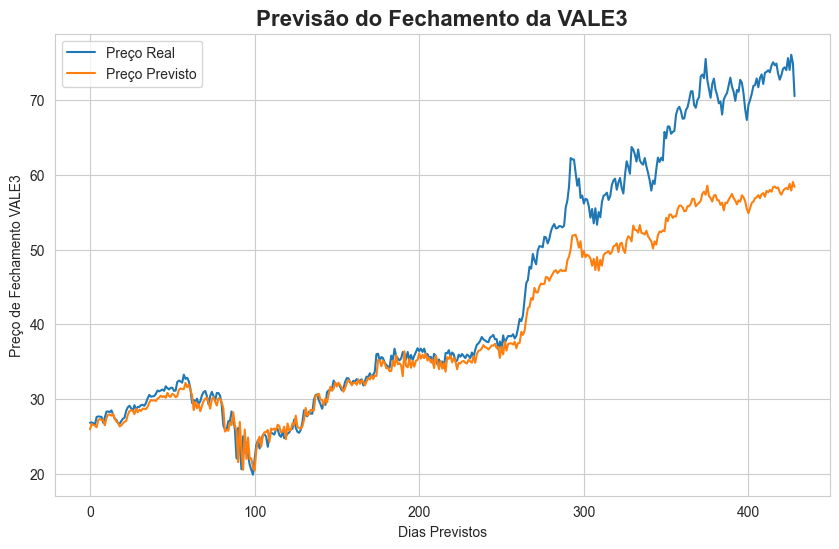

In [183]:
## 11. Gráfico

plt.figure(figsize = (10, 6))
sns.set_style('whitegrid')

plt.plot(y_real, label='Preço Real')
plt.plot(pred_real, label='Preço Previsto')

plt.xlabel('Dias Previstos')
plt.ylabel('Preço de Fechamento VALE3')
plt.title('Previsão do Fechamento da VALE3', fontweight='bold', fontsize=16)
plt.legend()

plt.show()

In [184]:
## 11. Tempo Final de Compilação

_end_time = time.time() - _start_time
print(f"Tempo total de execução: {_end_time:.2f} segundos")

Tempo total de execução: 211.66 segundos
